# Tensor Field Network Elastic Tensor Predictions 

In [1]:
import torch
torch.set_default_dtype(torch.float64)
import torch_geometric as tg
from torch_scatter import scatter_add, scatter_mean
import e3nn
from e3nn import rs, o3
from e3nn.networks import GatedConvParityNetwork
from e3nn.tensor import CartesianTensor
from e3nn.point.message_passing import Convolution
from e3nn.point.data_helpers import DataPeriodicNeighbors
import pymatgen
from pymatgen.ext.matproj import MPRester
import numpy as np

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. Data Query and Preprocessing 

Here, we will query 22 elasticity tensors from the Materials Project Database. These all belong to different phases of SiO$_{2}$ (constant composition, but these phases exist at various pressures and temperatures across the Si-O phase diagram). [Note: Error below originated while running this codeblock on 12/15 when Materials Project database was shut down. Data previously queried]. 

In [2]:
## Perform Data Query for Compounds with SiO2 composition  
with MPRester("jSMwykbKMFam0seE") as m:
    # Structure for material id
    dataset_all = m.get_data("SiO2", prop="elasticity")
dataset_contains_elasticity = [] ## all SiO2 compounds with availible elasticity tensors 
for item in dataset_all: 
    if item["elasticity"]:
        dataset_contains_elasticity.append(item)
    else: 
        continue 
## Seperate dataset into material ID, elasticity tensor, structure         
dataset_material_ids = [] 
dataset_elasticity_tensors = [] 
dataset_structures  = [] 
for item in dataset_contains_elasticity: 
    dataset_material_ids.append(item['material_id'])
    dataset_elasticity_tensors.append(np.array(dataset_contains_elasticity[0]['elasticity']['elastic_tensor_original']))
    with MPRester("jSMwykbKMFam0seE") as m:
        struct = m.get_structure_by_material_id(item['material_id']) 
        dataset_structures.append(struct)
        

Elasticity tensors queried from Materials Project originally in Voigt notation (engineering notation). Function below implemented to convert from Voigt to Cartesien notation (the format that's read in by the neural network).  

In [3]:
## Helper function to convert elasticity tensors from Voigt to cartesian notation
def voigt_to_cartesian(voigt):
    voigt_map = {(1, 1): 1, (2, 2): 2, (3, 3): 3, (2, 3): 4, (1, 3): 5, (1, 2): 6}
    cartesian = np.zeros((3, 3, 3, 3), dtype=np.float64)
    for i in range(1, 3+1):
        for j in range(1, 3+1):
            for k in range(1, 3+1):
                for n in range(1, 3+1):
                    p = (i, j) if i <= j else (j, i)
                    s = (k, n) if k <= n else (n, k)
                    cartesian[i-1, j-1, k-1, n-1] = voigt[voigt_map[s]-1, voigt_map[p]-1]
    return cartesian 

Peform necessary conversions from Voight to Cartesian. $Q$ matrices then obtained to convert Cartesian tensors to an irreduciable form. Irreduciable formed obtaiend by acting $Q$ on the cartesian tensor. This converts an 81 element tensor to a 21 element vector by leveraging permutation and rotational symmetry. 

In [4]:
## Convert elasticity tensors from Voigt to Cartesian notation 
dataset_elasticity_tensors_cart = [] 
for item in dataset_elasticity_tensors:
    temp = voigt_to_cartesian(item)
    dataset_elasticity_tensors_cart.append(torch.from_numpy(np.array(temp)))

## Get Q matrices 
Q_matrices_elastic = [] #Representations tensors, Q   
Rs_outs = [] # Representations of elasticity tensors 
for item in dataset_elasticity_tensors_cart:
    cart = CartesianTensor(item, 'ijkl=jikl=klij')
    Rs_out, Q = cart.to_irrep_transformation() 
    Q_matrices_elastic.append(Q)
    Rs_outs.append(Rs_out)   
    
## Convert to Irrep
dataset_elasticity_tensors_cart_irrep = [] 
for i in range(len(dataset_elasticity_tensors_cart)):
    Q = Q_matrices_elastic[i]
    tens = dataset_elasticity_tensors_cart[i]
    irrep = torch.einsum('ix,x->i', Q, tens.reshape(-1))
    dataset_elasticity_tensors_cart_irrep.append(torch.reshape(irrep,(1, 21) )) 

/Users/mithil/e3nn/e3nn/o3.py:463: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  res = xtx.symeig(eigenvectors=True)


Dataset containing atomic coordinates for each SiO$_{2}$ phase, converted to a structural representation to be read in by the network.

In [5]:
## Obtain input dataset (structural input)
struct_data = []
Rs_in = [(2, 0, 1)]
R_cut = 6.0
for item in dataset_structures: 
    dat = DataPeriodicNeighbors(torch.ones(len(item), 1), Rs_in, item.cart_coords, item.lattice, R_cut)
    struct_data.append(dat) 
    

/Users/mithil/e3nn/e3nn/point/data_helpers.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  cart = torch.tensor(cart)


Training set now established, containing (x_train_sio2, y_train_sio2). x_train_sio2 contains atomic represesntations for each SiO$_{2}$ phase and y_train_sio2 contains set of elasticity tensors for each phase in an irreduciable form. 

In [6]:
## Establish training set
x_train_sio2 = struct_data
y_train_sio2 = dataset_elasticity_tensors_cart_irrep  

# II. Setup Network Architecture

We use the e3nn package to implement a Gated Convolution Parity Network here. Our specific architecture contains 4 layers, taking in an atomic representation as an input and outputs a representation of a fourth-rank tensor. The radial basis function was used as the radial component of the point convolution. The network architecture closely follows that in the schematic below: 
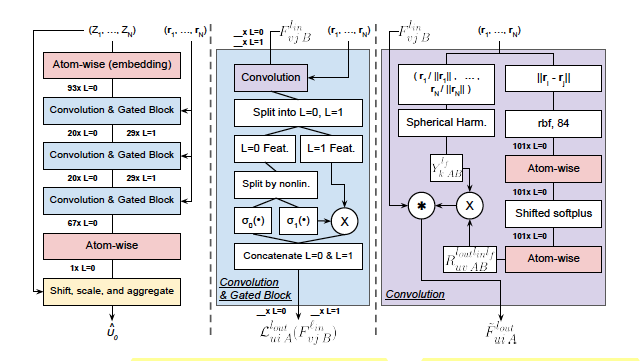

In [7]:
Q = Q_matrices_elastic[0]
Rs_out = Rs_outs[0]
N_atom_types = 1 # 2 atom types: Si and O 
Rs_in = [(N_atom_types, 0, 1)] # Input tensor representation 
Rs_out = Rs_out  # Output tensor representation 
r_max = 6.0 # Radial cutoff in Ang. 

model_kwargs = { #Network inputs 
    'convolution': Convolution,
    'Rs_in': Rs_in,  # one scalar and one L=2, both with even parity
    'Rs_out': Rs_out,
    'mul': 4, 'lmax': 4, 'layers': 3,
    'max_radius': r_max,  # from dataset
    'number_of_basis': 10,
} ##changed Lmax from 2 to 4

class AggregateAtoms(torch.nn.Module): # Network object 
    def __init__(self, network):
        super().__init__()
        self.network = network
        
    def forward(self, input, *args, **kwargs):
        N = input.shape[0]
        if 'batch' in kwargs:
            batch = kwargs['batch']
        else:
            batch = torch.zeros(N).to(torch.int64)
        output = self.network(input, *args, **kwargs)
        output = scatter_mean(output, batch, dim=0)
        return output
    
network = GatedConvParityNetwork(**model_kwargs)
model = AggregateAtoms(network)
n_norm = 50  ## normalization set to 50  

# III. Train architecture

First we the model to overfit on a single SiO$_{2}$ elasticity tensor. We train this for 300 epochs, using the Adam optimizer, and learning rate of 0.01. [Eventually cut short to 171 epochs for convergence was achievced]

In [38]:
def main():
    outs = [] # output tensors 
    loss_values = []  #loss values 
    network = GatedConvParityNetwork(**model_kwargs) # define network 
    model = AggregateAtoms(network) #define model 
    torch.set_default_dtype(torch.float64)
    x_train = x_train_sio2 # atomic representations 
    y_train = y_train_sio2 # elaticity tensors 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  #Adam optimizer 
    loss_func = torch.nn.MSELoss()
    i = 0  
    for step in range(300): #Train for 300 epochs 
        for n in range(10):
            losses = []
            out = model(x_train[n].x, x_train[n].edge_index, x_train[n].edge_attr, n_norm=n_norm) 
            outs.append(out.detach())
            oneloss = loss_func(out, y_train[n])
            losses.append(oneloss)
        loss = sum(losses)/len(losses)
        loss_values.append(loss.item())
        print("iter: " +str(i)+ " loss: " +str(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1 
    return model, outs, loss_values

In [35]:
if __name__ == '__main__':
    model, outs,losses =  main()

iter: 0 loss: 3149.3181791539882
iter: 1 loss: 2525.864019359387
iter: 2 loss: 1522.9270239337682
iter: 3 loss: 14883.433250312613
iter: 4 loss: 1224.5273666837425
iter: 5 loss: 1925.8017224538385
iter: 6 loss: 1927.2037977361429
iter: 7 loss: 1931.1464050155482
iter: 8 loss: 1834.5828586955593
iter: 9 loss: 1651.9697021874163
iter: 10 loss: 1379.3653127435443
iter: 11 loss: 1008.6417985805452
iter: 12 loss: 582.6572264081814
iter: 13 loss: 260.0821954796297
iter: 14 loss: 360.4973051515834
iter: 15 loss: 653.112261236934
iter: 16 loss: 248.49917940051776
iter: 17 loss: 1096.974901591349
iter: 18 loss: 218.53514600647136
iter: 19 loss: 219.15243754783404
iter: 20 loss: 219.5491679849922
iter: 21 loss: 221.44210869718214
iter: 22 loss: 223.08008943622892
iter: 23 loss: 222.71481993088187
iter: 24 loss: 221.66859271856455
iter: 25 loss: 220.3690663403685
iter: 26 loss: 218.2348546435945
iter: 27 loss: 215.82746077587694
iter: 28 loss: 214.37809874582265
iter: 29 loss: 214.15493572226865


iter: 240 loss: 213.43790294339934
iter: 241 loss: 213.43790294357785
iter: 242 loss: 213.43790294322466
iter: 243 loss: 213.4379029424928
iter: 244 loss: 213.43790294234367
iter: 245 loss: 213.43790294226716
iter: 246 loss: 213.43790294259585
iter: 247 loss: 213.43790294285628
iter: 248 loss: 213.43790294275865
iter: 249 loss: 213.43790294260066
iter: 250 loss: 213.43790294222725
iter: 251 loss: 213.4379029421739
iter: 252 loss: 213.43790294228018
iter: 253 loss: 213.4379029424043
iter: 254 loss: 213.4379029425167
iter: 255 loss: 213.43790294238426
iter: 256 loss: 213.43790294228296
iter: 257 loss: 213.4379029421632
iter: 258 loss: 213.437902942145
iter: 259 loss: 213.43790294224132
iter: 260 loss: 213.437902942282
iter: 261 loss: 213.43790294231272
iter: 262 loss: 213.4379029422273
iter: 263 loss: 213.43790294215782
iter: 264 loss: 213.4379029421387
iter: 265 loss: 213.43790294214728
iter: 266 loss: 213.43790294220318
iter: 267 loss: 213.4379029422059
iter: 268 loss: 213.437902942198

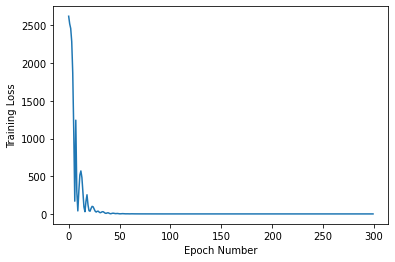

In [12]:
### Note: run cut off early and losses weren't saved. Instead copied loss values and saved to external text file for plotting 
#loss = np.loadtxt("loss.txt")

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(losses)

ax.set(xlabel='Epoch Number', ylabel='Training Loss')

plt.show()

Model trained for 171 epochs and final training loss of ~3.928 obtained for single phase SiO$_{2}$.  Illustrating that onset to convergence after 50 epochs.   

Now we test this model on the entre SiO$_{2}$ elasticty tensor dataset, utilizing the same hyperparamaters as in the training session above. Now trained for 50 epochs. 

In [13]:
## Establish testing set
x_test_sio2 = struct_data
y_test_sio2 = dataset_elasticity_tensors_cart_irrep

In [14]:
def main():
    outs = [] # output tensors 
    loss_values = []  #loss values 
    network = GatedConvParityNetwork(**model_kwargs) # define network 
    model = AggregateAtoms(network) #define model 
    torch.set_default_dtype(torch.float64)
    x_test = x_test_sio2 # atomic representations 
    y_test = y_test_sio2 # elaticity tensors 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  #Adam optimizer 
    loss_func = torch.nn.MSELoss()
    i = 0  
    for step in range(50): #test for 50 epochs 
        for n in range(5):
            losses = []
            out = model(x_test[n+17].x, x_test[n+17].edge_index, x_test[n+17].edge_attr, n_norm=n_norm) 
            outs.append(out.detach())
            oneloss = loss_func(out, y_test[n+5])
            losses.append(oneloss)
        loss = sum(losses)/len(losses)
        loss_values.append(loss.item())
        print("iter: " +str(i)+ " loss: " +str(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1 
    return outs, loss_values

In [33]:
output = [] # output tensors 
loss_values = []  #loss values 
network = GatedConvParityNetwork(**model_kwargs) # define network 
model = AggregateAtoms(network) #define model 
torch.set_default_dtype(torch.float64)
x_test = x_test_sio2 # atomic representations 
y_test = y_test_sio2 # elaticity tensors 
loss_func = torch.nn.MSELoss()
testmodel = model(x_test[21].x, x_test[21].edge_index, x_test[21].edge_attr, n_norm=n_norm)
outs.append(testmodel.detach())
loss = loss_func(testmodel, y_test[21])
print(" loss: " +str(loss.item()))

 loss: 2537.076520291755
